# Implementing Logistic Model of Custody Level (Following Methods Used by ProPublica)

Modeling in the same way as for the COMPAS data but with our dataset for the upcoming UPSTAT Conference.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from IPython.display import Image
import pydotplus
from sklearn import tree

%matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
df = pd.read_csv("../data/initial_custody_gsprs.csv", low_memory=False)

In [5]:
df["age_gt_45"] = ((2021 - (df.date_of_birth/10000)\
    .astype(int)) > 45)\
    .apply(lambda x: 1 if x else 0)

In [6]:
df["age_lt_25"] = ((2021 - (df.date_of_birth/10000)\
    .astype(int)) < 25)\
    .apply(lambda x: 1 if x else 0)

In [7]:
df["gender_female"] = df.sex.transform(lambda x: 1 if x == "M" else 0)

In [8]:
df = pd.concat([df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)], axis=1)

In [9]:
df["custody_level"] = df.ic_custdy_level.transform(lambda x: 0 if x <= 3 else 1)

In [10]:
df["prior_commits"] = df.ic_prior_commits

In [11]:
df["escape_hist_1"] = df.ic_escpe_hist_1.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_2"] = df.ic_escpe_hist_2.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_3"] = df.ic_escpe_hist_3.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_4"] = df.ic_escpe_hist_4.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_5"] = df.ic_escpe_hist_5.transform(lambda x: 1 if str(x) == "X" else 0)

In [12]:
df = pd.concat([df, pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat").drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)], axis=1)

In [13]:
df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)

In [14]:
def plot_custody_level_by_race(df, normalize=True):
    fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
    black_cust_levels = df[df.race == "B"].ic_custdy_level.value_counts(normalize).sort_index()
    white_cust_levels = df[df.race == "W"].ic_custdy_level.value_counts(normalize).sort_index()

    axs[0].bar(np.arange(len(black_cust_levels)), black_cust_levels.values)
    axs[0].set_xticks(np.arange(len(black_cust_levels)))
    axs[0].set_xticklabels(black_cust_levels.index.values)
    axs[0].set_title("Black inmates' custody level")
    axs[0].set_ylabel("{}".format("Frequency" if normalize else "Count"))
    axs[0].set_xlabel("Custody Level")

    axs[1].bar(np.arange(len(white_cust_levels)), white_cust_levels.values)
    axs[1].set_xticks(np.arange(len(white_cust_levels)))
    axs[1].set_xticklabels(white_cust_levels.index.values)
    axs[1].set_title("White inmates' custody level")
    axs[1].set_ylabel("{}".format("Frequency" if normalize else "Count"))
    axs[1].set_xlabel("Custody Level")

In [15]:
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

In [16]:
len([
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ])

23

In [17]:
data = data.dropna()

In [18]:
len(data)

29622

In [19]:
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, stratify=Y)

In [20]:
model = RandomForestClassifier()

In [21]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [21]:
y_pred_test = model.predict(X_test)

In [22]:
accuracy_score(Y_test, y_pred_test)

0.8871185525249797

In [23]:
confusion_matrix(Y_test, y_pred_test)

array([[4443,  343],
       [ 493, 2127]])

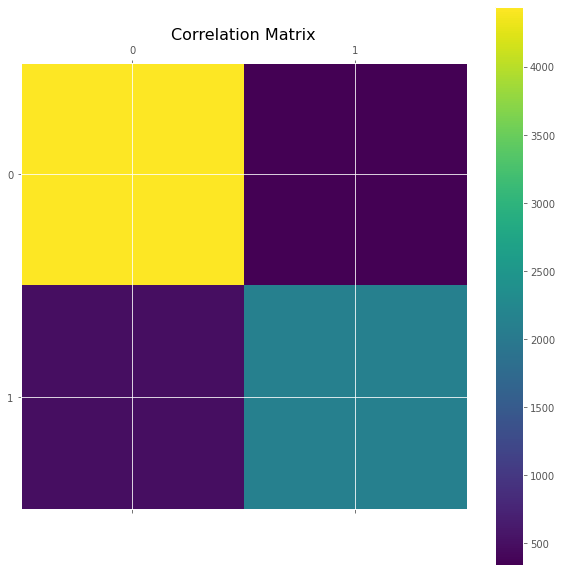

In [24]:
f = plt.figure(figsize=(10, 10))
plt.matshow(confusion_matrix(Y_test, y_pred_test), fignum=f.number)
# plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14, rotation=45)
# plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [25]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4786
           1       0.86      0.81      0.84      2620

    accuracy                           0.89      7406
   macro avg       0.88      0.87      0.87      7406
weighted avg       0.89      0.89      0.89      7406



Random Forest: ROC AUC=0.946


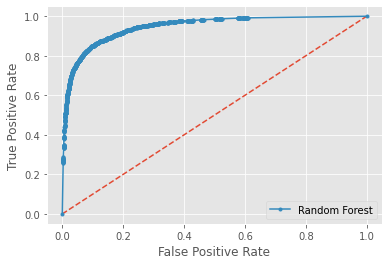

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(Y_test))]

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [27]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [28]:
len(model.estimators_)

100

In [29]:
model.estimators_[0].decision_path(X_test.iloc[0].values.reshape(1, -1))

<1x6565 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [30]:
# from:
# https://programmerbackpack.com/introduction-to-random-forests-classifier-and-step-by-step-sklearn-implementation/

def print_tree(classifier, index, max_depth=None):
    feature_names = X.columns.values
    target_names = [str(i) for i in Y.unique()]
    
    dot_data = tree.export_graphviz(classifier, out_file=None,
                                    feature_names=feature_names,
                                    class_names=target_names,
                                    max_depth=max_depth)
    # Build the graph
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    # Write the image
    # Image(graph.create_png())
    graph.write_png("../plots/tree" + str(index) + ".png")

In [31]:
print_tree(model.estimators_[0], 0)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.185246 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.185246 to fit



In [32]:
importances = model.feature_importances_

In [33]:
sorted_indices = np.argsort(importances)[::-1]

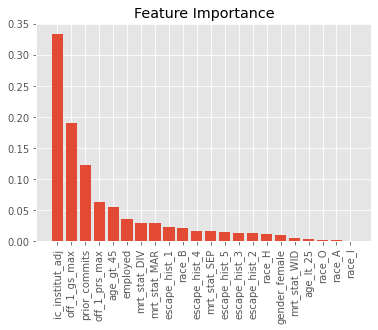

In [35]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.show()

In [33]:
classifier, index = model.estimators_[0], 0
feature_names = X.columns.values
target_names = [str(i) for i in Y.unique()]

dot_data = tree.export_graphviz(classifier, out_file=None,
                                feature_names=feature_names,
                                class_names=target_names,
                                max_depth=5)
# Build the graph
graph = pydotplus.graph_from_dot_data(dot_data)

In [34]:
graph.write_png("test.png")

True

In [32]:
graph.write_svg("test.svg")

True